<ipython-input-36-9f1cd2b68d55>:179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)
<ipython-input-36-9f1cd2b68d55>:186: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
<ipython-input-36-9f1cd2b68d55>:179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created

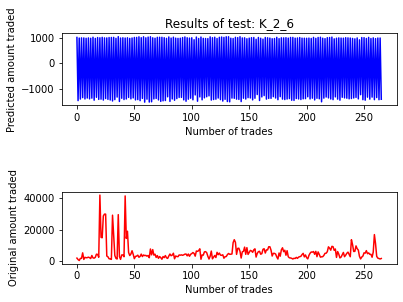

In [36]:
import os
import csv
import string
import random
import numpy as np
import pandas as pd
from scipy import optimize as optim
from scipy.stats import norm
from scipy.stats import mode
from scipy.stats import bartlett
from scipy.stats import sem
from scipy.stats import ttest_ind
from statistics import NormalDist
import matplotlib.pyplot as plt


#function to calculate optimal ß0
def calculatebeta(potarray, varV, varS, varZ, varE, eps):
    varV = varV**2
    varS = varS**2
    
    betaisfound = False
    for x in range(0, potarray.size):
        beta = potarray[x]
        lambda0 = (beta*varV) / ((beta**2) * varS * varZ)
        varVdx1 = (((beta**2) * varE * varZ)/((beta**2)*varS*varZ))*varV
        varSdx1 = (varZ/((beta**2)*varS*varZ))*varS
        theta = varV / (varS*varE)
        lambda1 = (1/(varZ**0.5))*np.sqrt((theta/2)*(varVdx1 - (theta/2 * varSdx1)))
        w1 = 1/4*lambda1
        condition = (theta/2*lambda0)*((1-2*w1*lambda0)/(1-w1*lambda0))
        if beta >= condition - eps and beta <= condition + eps:
            betaisfound = True
            return beta, lambda0, lambda1, theta, w1;
    if betaisfound == True:
        print('ß0 was succesfully found!')
    else:
        print('ß0 was not found')
    return 1, 1, 1, 1, 1;

#function to predict size and value of stock
def predict_v_and_dx(df_size, df_values, estd, dzstd, sample, margin, potß0min, potß0max, potß0num, ticker):
    
    #creating an array, where first column Bid, second column Ask, third column mean; and where the unknown Ask or Bid price is same as the previous
    #also creating s array which contains the value of the stock, average spread, and a random noise
    #s = v + e, where e ~ N(0, estd)

    df_spread = np.zeros((df_values.size, 3))
    df_s = np.zeros(df_values.size)
    for x in range(0, df_values.size):
        if x == 0 and ticker == 'ms':
            df_spread[0, 1] = df_values[0]
            df_spread[0, 0] = df_values[1]
            df_spread[0, 2] = (df_spread[0, 0] + df_spread[0, 1])/2
            df_s[x] = df_spread[x, 2] + np.random.normal(0, estd)
        elif x== 0 and ticker == 'otp':
            df_spread[0, 0] = df_values[0]
            df_spread[0, 1] = df_values[1]
            df_spread[0, 2] = (df_spread[0, 0] + df_spread[0, 1])/2
            df_s[x] = df_spread[x, 2] + np.random.normal(0, estd)
        else:
            if df_type[x] == "BEST_ASK":
                df_spread[x, 1]= df_values[x]
                df_spread[x, 0]= df_spread[x-1, 0]
                df_spread[x, 2]= (df_spread[x, 0] + df_spread[x, 1])/2
                df_s[x] = df_spread[x, 2] + np.random.normal(0, estd)
            elif df_type[x] == "BEST_BID":
                df_spread[x, 1]= df_spread[x-1, 1]
                df_spread[x, 0]= df_values[x]
                df_spread[x, 2]= (df_spread[x, 0] + df_spread[x, 1])/2
                df_s[x] = df_spread[x, 2] + np.random.normal(0, estd)

    #creating the five set packages, summing the total amount of trading shares, and averaging the bid-ask spreads in those packages
    df5_spread = np.zeros((df_spread[:,0].size//5, 3))
    for j in range(0, df_spread[0,:].size):
        for x in range(0, df5_spread[:,j].size):
            df5_spread[x,j] = np.mean(df_spread[x*5:(((x+1)*5)-1), j])

    df5_size = np.zeros(df_size.size//5)
    for x in range(0, df5_size.size):
        df5_size[x] = np.round_(np.sum(df_size[x*5:(((x+1)*5)-1)])) 

    df5_s = np.zeros(df_spread[:,0].size//5)
    for x in range(0, df5_s.size):
        df5_s[x] = np.mean(df_s[x*5: (((x+1)*5)-1)]) 
    
    #creating arrays into which the predicted values will go
    df5_spread_predict = np.zeros(df5_spread[:, 0].size-sample)
    df5_size_predict = np.zeros(df5_size.size-sample)

    # creating an array for potential ß0 values. Name standing for Rhesus monkey array, representing the fact that this array is experimented on 
    rharr = np.linspace(potß0min, potß0max, potß0num)
     
    for x in range(0, df5_spread_predict.size):
        if x%2 == 0:
            #calculating standard deviation of v on the given sample
            vmu = np.mean(df5_spread[x:x+sample-1, 2]) 
            vstd = np.std(df5_spread[x:x+sample-1, 2])
        
            #calculating standard deviation of s on the given sample
            smu = np.mean(df5_s[x:x+sample-1])
            sstd = np.std(df5_s[x:x+sample-1])
        
            #approximating optimal ß0, and thus all the other parameters associated with it
            ß0, L0, L1, Th, w1 = calculatebeta(rharr, vstd, sstd, estd, dzstd, margin)
        
            #calculating predicted delta xt for the next  trade, dxt = dyt + dzt
            df5_size_predict[x] = (ß0 * df5_s[x+sample]) + np.random.normal(0, dzstd)
        
            #calculating predicted price for next trade
            df5_spread_predict[x] = L0 * df5_size_predict[x]
        
            #calculating predicted delta xt for the trade after the next, dxt = dyt + dzt
            df5_size_predict[x+1] = (-df5_spread_predict[x]/(2*L1))+((Th/(2*L1))*df5_s[x+sample]) + np.random.normal(0, dzstd)
        
            #calculating predicted price for the trade after the next trade
            df5_spread_predict[x+1] = df5_spread_predict[x] + (L1*df5_size_predict[x+1])
    
    
    for x in range(0, df5_spread_predict.size):
        if np.isnan(df5_size_predict[x]) == True or np.isfinite(df5_size_predict[x]) == False:
            df5_size_predict[x] = 100
        if np.isnan(df5_spread_predict[x]) == True or np.isfinite(df5_spread_predict[x]) == False:
            df5_spread_predict[x] = 100
    
    return df5_spread_predict, df5_size_predict, df5_spread, df5_size;




def results(predv, s, predsize, size, filepath, testname):
    res = np.zeros(14)
    diff = size.size - predsize.size
    
    #calculating indicators for the predicted price array
    #calculating expected value and  standard deviation from original spred,
    res[0], res[1] = norm.fit(s[diff:,2])
    
    #calculating expected value and  standard deviation from predicted price values
    res[2], res[3] = norm.fit(predv)
    
    #calculating the most common value of the original spread
    res[4], trash = mode(s[diff:,2])
    #calculating the most common value of the predicted values
    res[5], trash = mode(predv)
    
    #calculating standard error of original spread
    res[6] = sem(s[diff:,2])
    #calculating standard error of predicted values
    res[7] = sem(predv)
    
    #bartlett test p value
    trash, res[8] = bartlett(s[diff:,2], predv) 
    
    # student test t value
    trash, res[9] = ttest_ind(s[diff:,2], predv)
    
    
    #calculating indicators for predicted size 
    #original average size value
    res[10] = np.mean(size[diff:])
    #original average size value
    res[11] = np.mean(predsize)
    
    maxdiff = 0
    differences = np.zeros(size[diff:].size)
    for x in range(0, size[diff:].size):
        differences[x] = np.absolute(predsize[x] - size[diff+x])
        if differences[x] > maxdiff:
            maxdiff = differences[x]
    
    #average difference of sizes
    res[12] = np.mean(differences)
    #max difference
    res[13] = maxdiff
    

    #ploting the original spread and the expected spread, then saving them
    plt.subplot(2, 1, 1)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1.2)
    plt.title('Results of test: ' + testname)
    plt.plot(predv, 'b-')
    plt.xlabel('Number of trades')
    plt.ylabel('Predicted average spread')

    plt.subplot(2, 1, 2)
    plt.plot(s[diff:, 2], 'r-')
    plt.xlabel('Number of trades')
    plt.ylabel('Original average spread')
    plt.savefig(testname+'_v', dpi=1000)
    
    plt.clf()
    
    plt.subplot(2, 1, 1)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1.2)
    plt.title('Results of test: ' + testname)
    plt.plot(predsize, 'b-')
    plt.xlabel('Number of trades')
    plt.ylabel('Predicted amount traded')
    
    plt.subplot(2, 1, 2)
    plt.plot(size[diff:], 'r-')
    plt.xlabel('Number of trades')
    plt.ylabel('Original amount traded')
    
    plt.savefig(testname + '_s', dpi=1000)
    
    #saving predicted values into xlsx
    toexcel = pd.DataFrame(data = {'PRED_VALUE': predv, 'PRED_SIZE' : predsize} )
    toexcel.to_excel(filepath, sheet_name = testname)
    
    return res


#opening data from excel
ticker = 'otp'
df = pd.read_excel("data.xlsx", sheet_name = ticker) 

#converting data to numpy arrays
df = df.to_numpy() 

#cropping our data, so it can be divided into five-set packages and dividing data to multiple arrays
crop = df.size%5

df_size = np.delete(df[: , 1], range(df.size-crop, df.size), None)
df_time = np.delete(df[: , 2], range(df.size-crop, df.size), None)
df_type = np.delete(df[: , 3], range(df.size-crop, df.size), None)
df_values = np.delete(df[: , 4], range(df.size-crop, df.size), None)

# e~N(0, estd) random noise
#dz standing for delta Z, e.g. the amount traded by noise traders dz ~ N(0,Sdz)
#size of set from which we derive the mean and variance of v, which is the value of the stock in question
#margin is important for the calculatebeta function, it basically determines the proximity of our ß0 to the optimal ß0
#potß0min and potß0max are the minimal and maximal values ß0 can be in our model, and potß0num is the number of potential ß0 values we want between the minimal and maximal values 

ind = np.zeros((14, 12))
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'ms')
ind[:, 0] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_1')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 20, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'ms')
ind[:, 1] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_2')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 50, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'ms')
ind[:, 2] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_3')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 40, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'ms')
ind[:, 3] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_4')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.4, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'ms')
ind[:, 4] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_5')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 300, potß0num = 59999, ticker = 'ms')
ind[:, 5] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_1_6')

predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'otp')
ind[:, 6] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_1')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 20, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'otp')
ind[:, 7] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_2')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 50, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'otp')
ind[:, 8] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_3')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 40, margin = 0.2, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'otp')
ind[:, 9] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_4')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.4, potß0min = 0.1, potß0max = 150, potß0num = 14999, ticker = 'otp')
ind[:, 10] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_5')
predv, predsize, spread, size= predict_v_and_dx(df_size, df_values, estd = 10, dzstd = 25, sample = 20, margin = 0.2, potß0min = 0.1, potß0max = 300, potß0num = 59999, ticker = 'otp')
ind[:, 11] = results(predv = predv, s=spread, predsize = predsize, size = size, filepath = 'Kyle_test_results.xlsx', testname = 'K_2_6')


In [38]:
toout = pd.DataFrame(data = {'Original mean value': ind[0,:], 'Original standard deviation' : ind[1,:], 'Predicted mean price' : ind[2,:], 'Predicted standard deviation of price' : ind[3,:], 'Mode value of original price' : ind[4,:], 'Mode value of predicted price' : ind[5,:], 'Standard error of mean for original original prices' : ind[6,:], 'Standard error of mean predicted for predicted prices' : ind[7,:], 'Bartlett test p value' : ind[8,:], 'Student test p value' : ind[9,:], 'Mean of original traded volumes' : ind[10,:], 'Mean of predicted traded volumes' : ind[11,:], 'Mean of differences' : ind[12,:], 'Maximal difference' : ind[13,:]} )

toout.to_excel('K_indicators.xlsx')